In [50]:
import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types

from functools import partial

import tqdm

from scipy.ndimage import minimum_filter1d

from dipper_methods import detect_dippers_row

In [51]:
%matplotlib notebook

In [52]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            #.config("spark.master", "local[32]") # yolo mode
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

# YOU NEED TO CHANGE THIS PATH
spark_session = spark_start("/epyc/users/jrad/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

In [9]:
# catalog.list_tables().keys()

In [128]:
# ztf = catalog.load('ztf_oct19')
wtf = catalog.load('wtf_full_oct19_3')

In [129]:
res_r = wtf.sort(wtf.score_r.desc()).head(1000)
res_g = wtf.sort(wtf.score_g.desc()).head(1000)

In [19]:
type(res_r[0])

pyspark.sql.types.Row

In [141]:
band_colors = {'g': 'C0',
               'r': 'C3',
               'i': 'k'}

def plot_lightcurve(row):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    
    for band in ['g', 'r', 'i']:
        mask = (
            (np.array(row[f'catflags_{band}']) == 0.)
        )
        def cc(x):
            return np.array(x)[mask]
        if sum(mask) > 0:
            plt.errorbar(cc(row[f'mjd_{band}']), 
                         cc(row[f'mag_{band}']), 
                         cc(row[f'magerr_{band}']),
                         fmt='o', c=band_colors[band], 
                         label=f'{band}', alpha=0.7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(labelsize=14)
    plt.xlabel('MJD', size=16)
    plt.ylabel('Magnitude', size=16)
    
    ra = row['ra']
    dec = row['dec']
    if dec > 0:
        sgn = '+'
    else:
        sgn = '–'
    dec = np.abs(dec) # bad practice, Meredith warned Jim against it
    coord = f'{ra:.3f} {sgn}{dec:.3f}'
    
    '''
    plt.plot([], [], ' ', label=coord)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = list(range(1, len(handles)))
    order.append(0)
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
               fancybox=True, framealpha=0.5, prop={'size':12}, ncol=2)
    '''
    plt.legend(fancybox=True, framealpha=0.5, prop={'size':12}, ncol=2)

#     plt.title('objid %d' % row['objid'])
    plt.gca().invert_yaxis()
    

In [143]:
def print_links(row):
    print("http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%.6f%+.6f&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=" % (row['ra'], row['dec']))
    print("RA+Dec: %.6f%+.6f" % (row['ra'], row['dec']))
    print("RA:     %.6f" % row['ra'])
    print("Dec:    %.6f" % row['dec'])
    
def print_score(band, row, num_sequential=3):
    score, mjd = detect_dippers_row(row, band, num_sequential=num_sequential, return_mjd=True)
    print(f"ZTF-{band}: Score: {score:.2f}, Max MJD: {mjd:.2f}")
    
def show_lightcurve(row):
#     print_links(row)
    print_score('g', row)
    print_score('r', row)
    print_score('i', row)

    plot_lightcurve(row)

ZTF-g: Score: 0.89, Max MJD: 58585.39
ZTF-r: Score: 35.49, Max MJD: 58558.50
ZTF-i: Score: -0.54, Max MJD: 58294.34


<IPython.core.display.Javascript object>


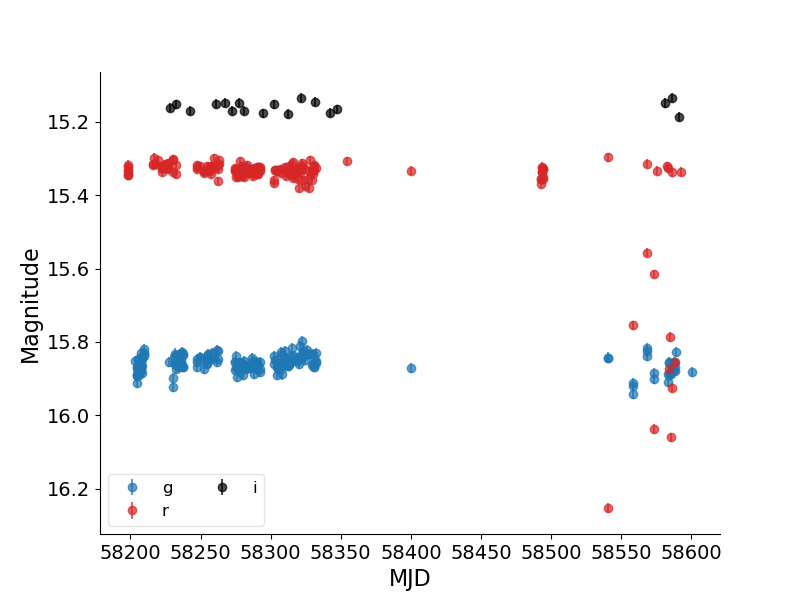

ZTF-g: Score: 25.83, Max MJD: 58307.34
ZTF-r: Score: 35.23, Max MJD: 58256.45
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


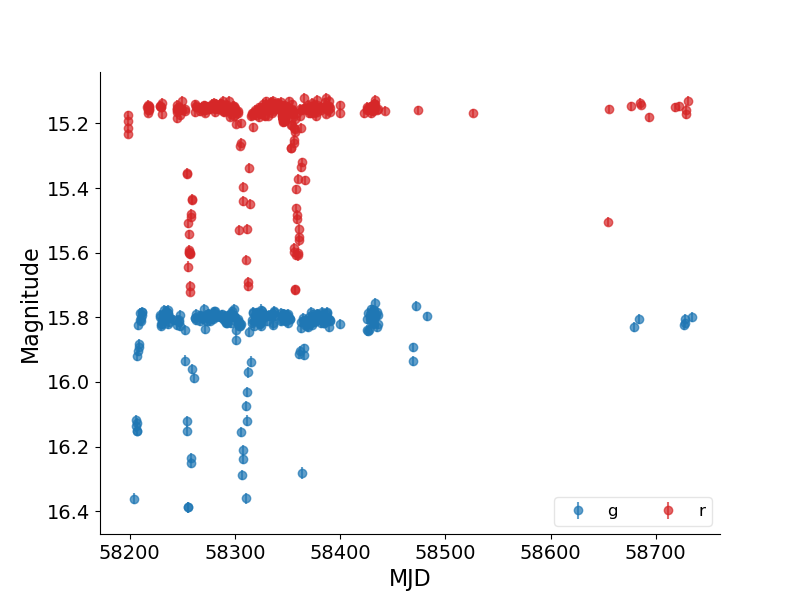

ZTF-g: Score: 1.66, Max MJD: 58381.19
ZTF-r: Score: 35.19, Max MJD: 58350.17
ZTF-i: Score: 1.27, Max MJD: 58272.36


<IPython.core.display.Javascript object>


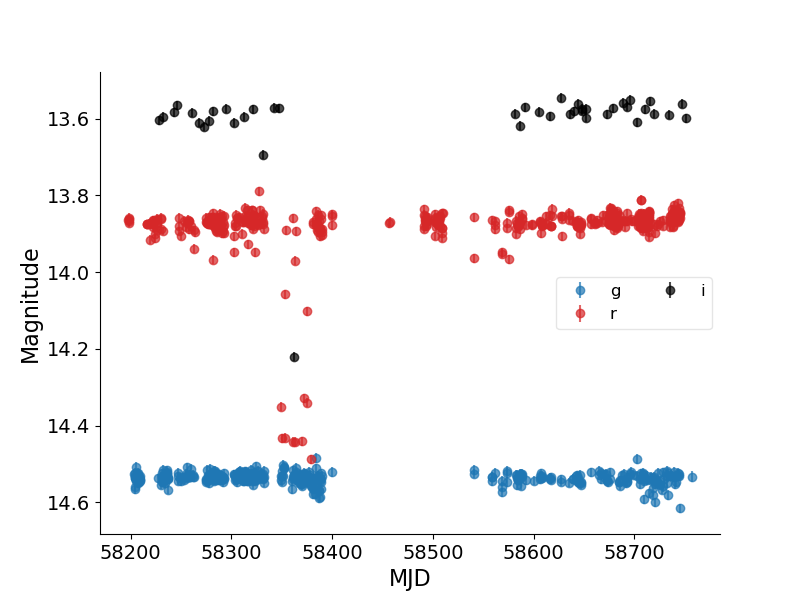

ZTF-g: Score: -1.00, Max MJD: nan
ZTF-r: Score: 34.86, Max MJD: 58457.08
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


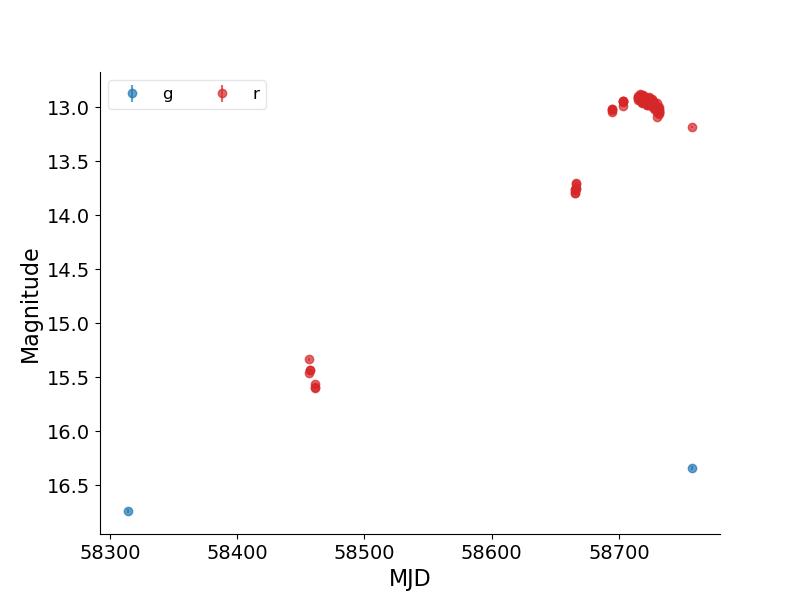

ZTF-g: Score: 1.66, Max MJD: 58244.45
ZTF-r: Score: 34.73, Max MJD: 58429.14
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


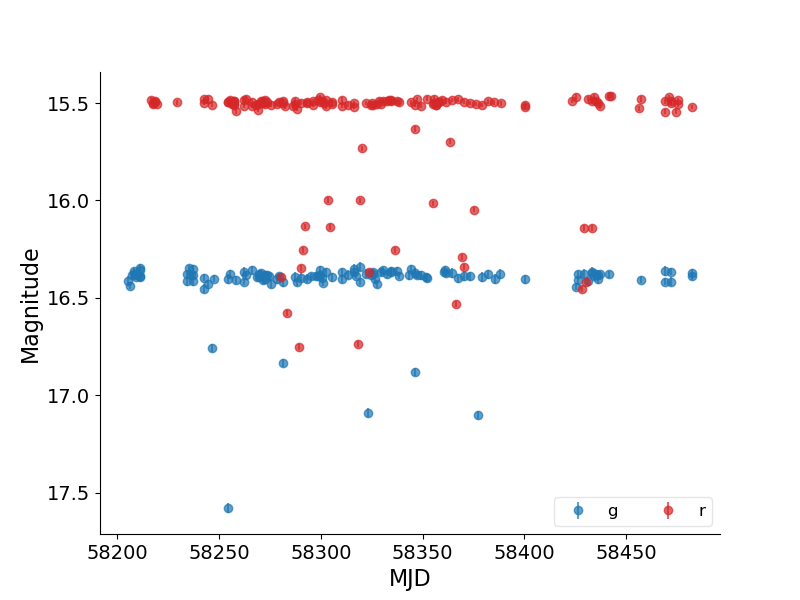

ZTF-g: Score: 8.72, Max MJD: 58387.52
ZTF-r: Score: 34.73, Max MJD: 58389.50
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


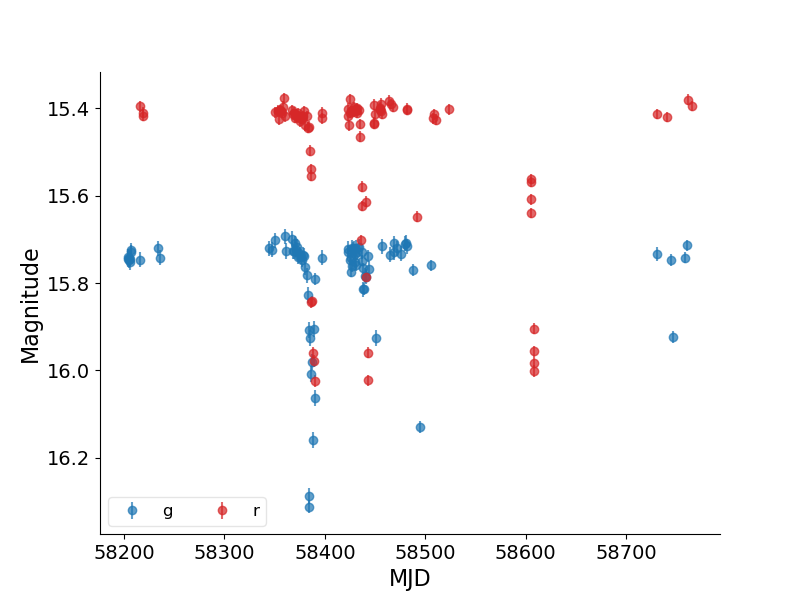

ZTF-g: Score: 0.40, Max MJD: 58332.22
ZTF-r: Score: 34.57, Max MJD: 58285.39
ZTF-i: Score: 1.58, Max MJD: 58281.31


<IPython.core.display.Javascript object>


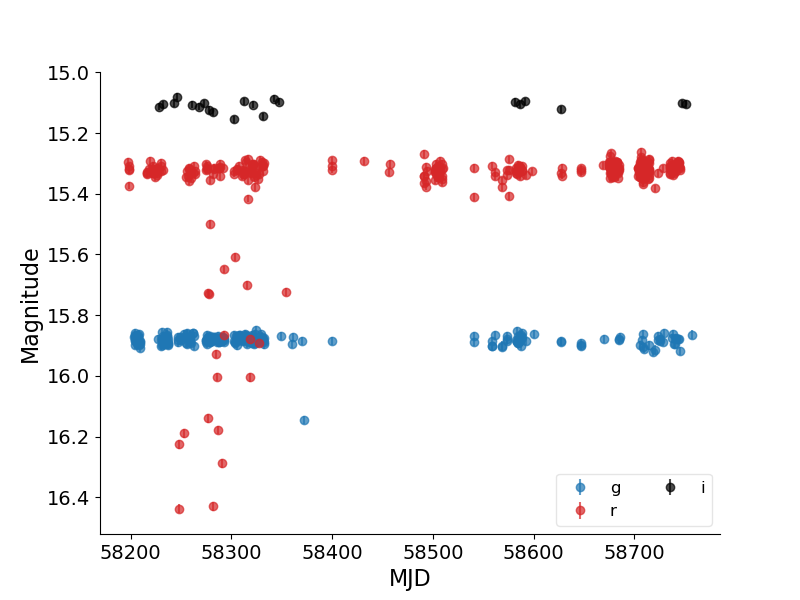

ZTF-g: Score: -1.00, Max MJD: nan
ZTF-r: Score: 34.55, Max MJD: 58665.33
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


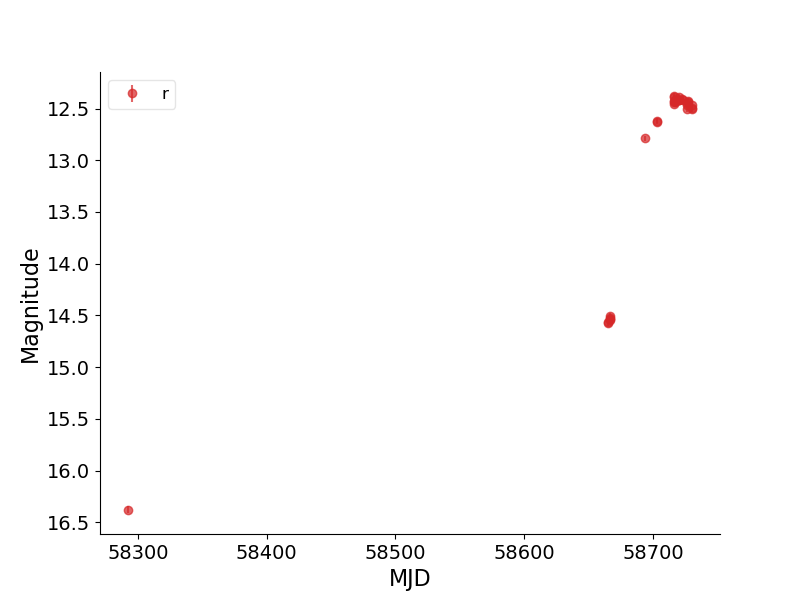

ZTF-g: Score: -1.00, Max MJD: nan
ZTF-r: Score: 34.09, Max MJD: 58724.23
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


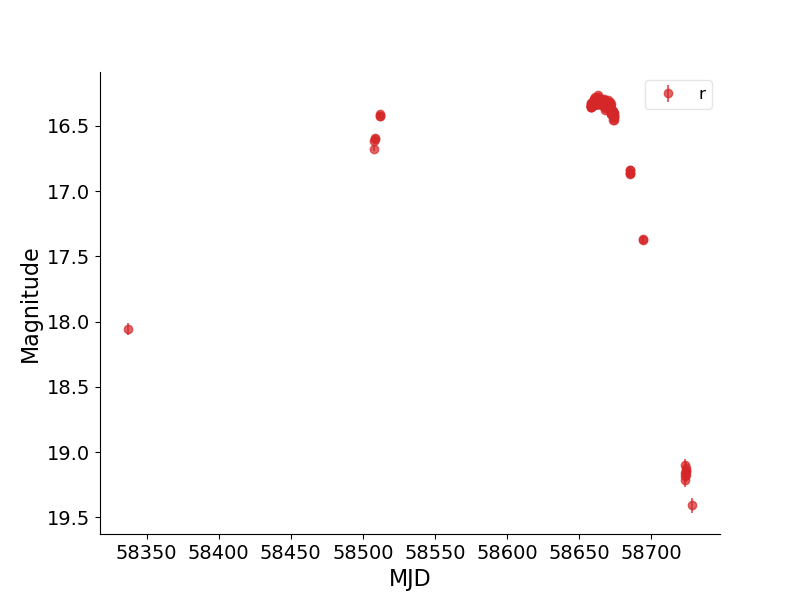

ZTF-g: Score: -1.00, Max MJD: nan
ZTF-r: Score: 33.97, Max MJD: 58275.40
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


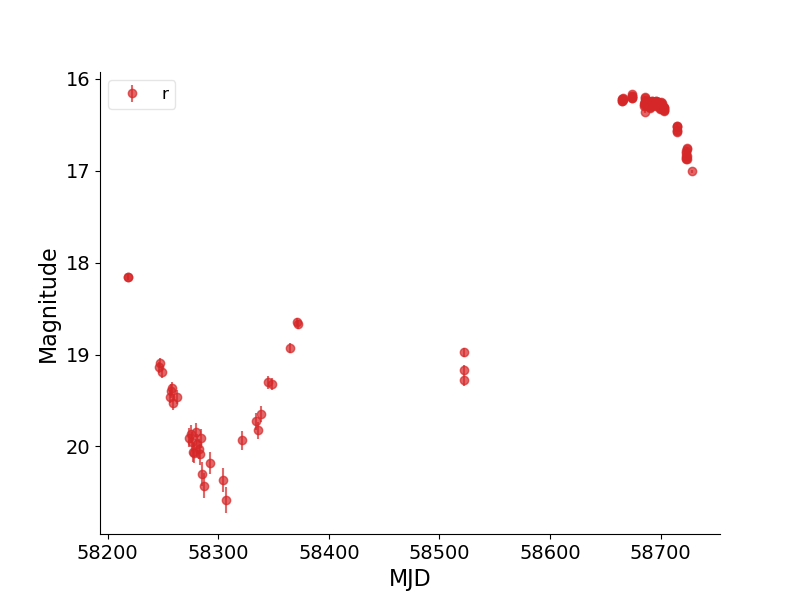

In [144]:
for k in range(100,110):
    show_lightcurve(res_r[k])

In [49]:

# for k in range(len(res_r)):
#     if np.isfinite(res_r[k].score_r):
#         print(k, res_r[k].score_r)

In [127]:
# handles, labels = plt.gca().get_legend_handles_labels()
# order = list(range(1, len(handles)))
# order.append(0)
# plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])


[1, 2, 3, 0]


TypeError: list indices must be integers or slices, not list

In [104]:
list(range(1,4))